# Project: Investigate the TMDb movie data
---

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data set contains metadata (such as title, director, keywords, revenue and user ratings) on around 10,000 movies collected from The Movie Database (TMDb). The data are originally from Kaggle but were cleaned before they were provided for this project. Here, we will investigate the relationship between average vote scores and various other variables in the data set. **vote_average** will be our dependent variable and we will explore genre, budget for the movie, and time of release as independent variables. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# let's load the data
df = pd.read_csv('tmdb-movies.csv')

In [3]:
# have a look at the first three rows to get a feeling for the data
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [4]:
# see what the dimensions of this dataframe are
df.shape

(10866, 21)

In [5]:
# let's have a closer look at each column, data types, and potentially missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [6]:
# we can see that there are a number of columns with missing values
# let's pull them up
# the following displays the percentage of missing values per column
(df.isnull().sum()/len(df)*100).round(decimals=2).sort_values(ascending=False)

homepage                72.98
tagline                 25.99
keywords                13.74
production_companies     9.48
cast                     0.70
director                 0.40
genres                   0.21
imdb_id                  0.09
overview                 0.04
popularity               0.00
budget                   0.00
revenue                  0.00
original_title           0.00
revenue_adj              0.00
budget_adj               0.00
runtime                  0.00
release_date             0.00
vote_count               0.00
vote_average             0.00
release_year             0.00
id                       0.00
dtype: float64

#### observations & takeaways:
- there are 10866 rows and 21 columns in this data set
- overall the data look fairly clean:
    - the column titles are all in small case and snake case
    - the data types look reasonable, maybe with the exception of release data which could be changed from a string to datetime
    - a few columns contain a large number of missing values: e.g. **production_companies**, **keywords**, **tagline**, and **homepage** with approximately 9%, 14%, 26%, 73% of the data missing, respectively; we need to proceed with care if we decide to include these variables in the analysis

In [7]:
# next let's have a look at the distribution of numerical variables
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


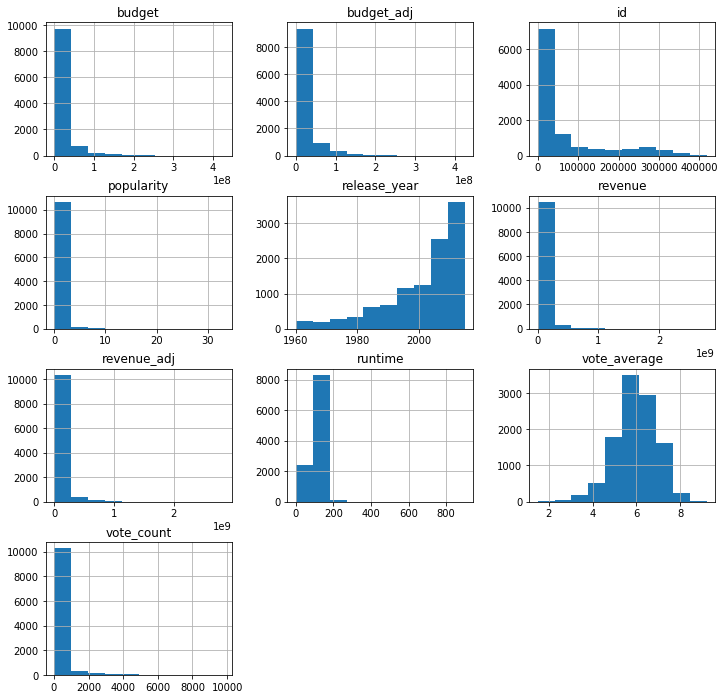

In [8]:
# provide a visual on the distribution of numerical variables
df.hist(figsize=(12,12));

In [9]:
# last not least, let's look for duplicated rows
df.duplicated().sum()

1

#### observations & takeaways:
- there are potential issues in columns **budget**, **revenue**, **budget_adj**, and **revenue_adj**; at least 50% of the values in these columns are 0; I'm assuming that these are missing values since it's highly unlikely that movies can be made with a budget of 0 or that they have 0 revenue; 
- in addition the data in columns **vote_count** and **popularity** are positively skewed with many small values and only a few very large values
- if we decide to use these columns later in the analysis we should be careful to deal with these cases before the analysis
- in contrast, **vote_average** seems well-behaved with a close-to normal distribution
- there is one duplicated row and we will remove it as part of the data cleaning process

### Data Cleaning

#### description of cleaning steps:
- we will remove columns that are not necessary for the analysis
- we will remove duplicate rows
- we will replace 0 values in **budget_adj** with numpy's NaN, so that they will not show up in plots and will not be involved in calculations such as mean or median; 
- we will create a new dataframe containing information on genres where each row contains only one genre

In [10]:
# in the analysis below we will explore the connection between vote average and different movie parameters
# remove columns that will not be used in our analysis
df.drop(['popularity','budget','revenue','director','cast','homepage','tagline','keywords','overview','production_companies','release_date','revenue_adj'], axis=1, inplace=True)
df.head(3)

,id,imdb_id,original_title,runtime,genres,vote_count,vote_average,release_year,budget_adj
0,135397,tt0369610,Jurassic World,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08
1,76341,tt1392190,Mad Max: Fury Road,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08
2,262500,tt2908446,Insurgent,119,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08


In [11]:
# remove duplicates from the dataset
df.drop_duplicates(inplace=True)

In [12]:
# replace 0 with NaN in budget_adj
# these data points will not show up in plots or influence calculations of mean or median
df['budget_adj'] = df['budget_adj'].replace(0, np.nan)

In [13]:
# then split genres into lists so that we can search them easily
df.genres = df.genres.str.split('|')
# then explode the lists so that if a movie is associated with multiple genres these now appear as independent rows
# the result is saved in a new dataframe called df_genres
df_genres = df.explode('genres')[['imdb_id','genres','vote_average']]

In [14]:
# let's have a quick look if the cleanup process worked as wanted
df.head(3)

,id,imdb_id,original_title,runtime,genres,vote_count,vote_average,release_year,budget_adj
0,135397,tt0369610,Jurassic World,124,"[Action, Adventure, Science Fiction, Thriller]",5562,6.5,2015,1.379999e+08
1,76341,tt1392190,Mad Max: Fury Road,120,"[Action, Adventure, Science Fiction, Thriller]",6185,7.1,2015,1.379999e+08
2,262500,tt2908446,Insurgent,119,"[Adventure, Science Fiction, Thriller]",2480,6.3,2015,1.012000e+08


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10865 non-null  int64  
 1   imdb_id         10855 non-null  object 
 2   original_title  10865 non-null  object 
 3   runtime         10865 non-null  int64  
 4   genres          10842 non-null  object 
 5   vote_count      10865 non-null  int64  
 6   vote_average    10865 non-null  float64
 7   release_year    10865 non-null  int64  
 8   budget_adj      5169 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 848.8+ KB


In [16]:
df.describe()

,id,runtime,vote_count,vote_average,release_year,budget_adj
count,10865.000000,10865.000000,10865.000000,10865.000000,10865.000000,5.169000e+03
mean,66066.374413,102.071790,217.399632,5.975012,2001.321859,3.688907e+07
std,92134.091971,31.382701,575.644627,0.935138,12.813260,4.196096e+07
min,5.000000,0.000000,10.000000,1.500000,1960.000000,9.210911e-01
25%,10596.000000,90.000000,17.000000,5.400000,1995.000000,8.102293e+06
50%,20662.000000,99.000000,38.000000,6.000000,2006.000000,2.271505e+07
75%,75612.000000,111.000000,146.000000,6.600000,2011.000000,5.008384e+07
max,417859.000000,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 0: What is the distribution of vote averages?

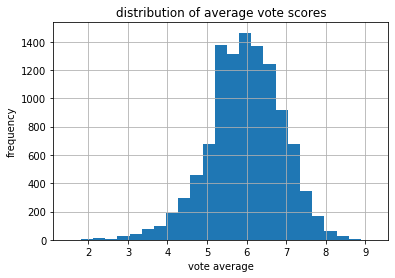

In [17]:
# before we start with our analysis let's have a closer look at our dependent variable **vote_average**
# let's plot the distribution of average voting scores
plt.hist(df.vote_average, bins=25)
plt.xlabel('vote average')
plt.ylabel('frequency')
plt.title('distribution of average vote scores')
plt.grid(True)
plt.show()

In [18]:
# this looks very close to a normal distribution
# calculate the mean and median of vote averages

In [19]:
'The mean of vote average is {}.'.format(df.vote_average.mean())

'The mean of vote average is 5.97501150483203.'

In [20]:
'The median of vote average is {}.'.format(df.vote_average.median())

'The median of vote average is 6.0.'

#### conclusions:
- average voting scores are close to normally distributed
- mean and median are almost identical: 5.97 and 6.0, respectively

### Research Question 1: What are the genres with the lowest and the highest vote averages?

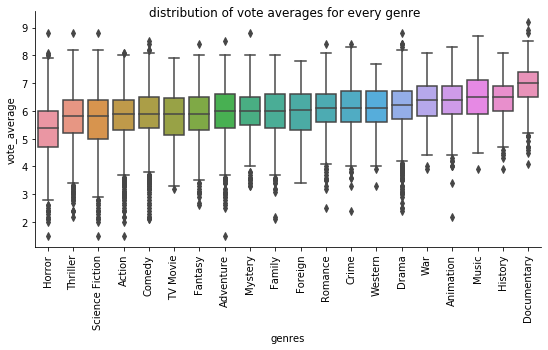

In [21]:
# we will use the df_genres dataframe to answer this question
# first we will calculate the median of vote averages per genre
# a sorted list of this will be used to sort the boxplot below
ordered_by_median = df_genres.groupby('genres', as_index=False).median().sort_values('vote_average').genres

# create a boxplot of vote averages for every genre
ax = sns.catplot(y="vote_average", x="genres", kind='box', data=df_genres, order=ordered_by_median, height=4, aspect=2)
ax.set_xticklabels(ordered_by_median, rotation=90)
ax.fig.suptitle('distribution of vote averages for every genre');

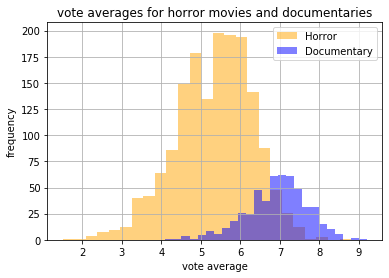

In [22]:
# looks like horror movies and documentaries are at both ends of the spectrum
# plot the vote averages for horror movies and documentaries as histograms to get a clearer picture
df_genres[df_genres['genres']=='Horror']['vote_average'].hist(bins=25, alpha=0.5, color='orange', label='Horror')
df_genres[df_genres['genres']=='Documentary']['vote_average'].hist(bins=25, alpha=0.5, color='blue', label='Documentary')
plt.legend()
plt.xlabel('vote average')
plt.ylabel('frequency')
plt.title('vote averages for horror movies and documentaries')
plt.show()

In [23]:
# run a two-sided t-test to test for independence between these two groups
a = df_genres[df_genres['genres']=='Horror']['vote_average']
b = df_genres[df_genres['genres']=='Documentary']['vote_average']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-34.06436920906358, pvalue=7.540083501885219e-204)

#### conclusions:
- on average horror movies have been getting the lowest average vote scores
- on average documentaries have been getting the highest average vote scores
- the difference in average vote scores between both categories is significant

### Research Question 2: Does a higher production budget result in higher vote averages?

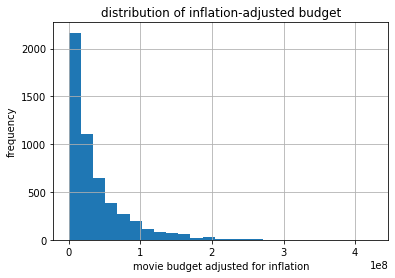

In [24]:
# first let's have a look at the distribution of budget_adj
df.budget_adj.hist(bins=25)
plt.xlabel('movie budget adjusted for inflation')
plt.ylabel('frequency')
plt.title('distribution of inflation-adjusted budget')
plt.grid(True)
plt.show()

In [25]:
# how many movies have missing values for budget_adj
# calculate the percentage of missing values
(df.budget_adj.isnull().sum()/len(df))*100

52.425218591808566

#### conclusions:
- the distribution of the movie budget is strongly skewed to the right (mean = \\$36 million, median = $23 million)
- only about 48% of the movies in this dataset have a budget reported (this needs to be taken into account when interpreting the results)

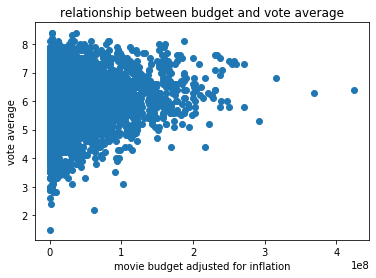

In [26]:
# plot vote averages against adjusted budget to visually inspect whether there is a linear relationship between both variables
x = df.budget_adj
y = df.vote_average
plt.scatter(x, y)
plt.xlabel('movie budget adjusted for inflation')
plt.ylabel('vote average')
plt.title('relationship between budget and vote average')
plt.grid(False)
plt.show()

In [27]:
# let's calculate a correlation coefficient 
# use spearman's rho since one of the variables (budget_adj) is not normally distributed
# first we need to remove missing values before we can calculate the correlation coefficient
sub = df[['budget_adj','vote_average']].dropna()
stats.spearmanr(sub['budget_adj'], sub['vote_average'])

SpearmanrResult(correlation=0.09630835622664663, pvalue=3.959455538788312e-12)

#### conclusions:
- there is no linear correlation between the budget spent on a movie and the vote average (spearman's rho is close to 0)

### Research Question 3: How have average voting scores changed over time? 

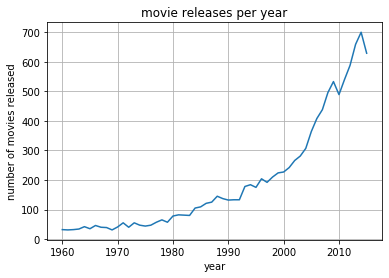

In [28]:
# how many movies have been released every year?
movies_per_year = df.groupby('release_year')['vote_average'].count()
plt.plot(movies_per_year)
plt.xlabel('year')
plt.ylabel('number of movies released')
plt.title('movie releases per year')
plt.grid(True)
plt.show()

In [29]:
# number of movies have steadily increased over the decades
# there are small variations in number of movies released from one year to another
# to get a more robust metric let's summarize releases per decade
df['decade'] = pd.cut(df['release_year'], range(1960,2021,10), labels=['60-70','70-80','80-90','90-00','00-10','10-20'])

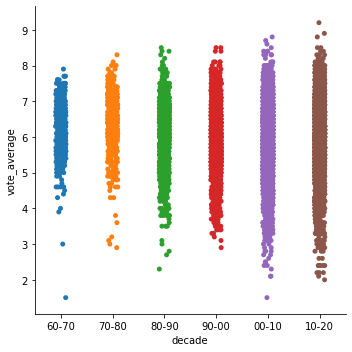

In [30]:
# plot vote averages for all movies released per decade
sns.catplot(y="vote_average", x="decade", data=df);

In [31]:
# this looks interesting: the distribution of vote averages have changes over the decades
# what are the mean and median of vote averages
# let's also have a look at the standard deviation to get a sense of the spread of the variable in every decade
df.groupby('decade', as_index=False).agg({'vote_average': ['size', 'mean', 'std', lambda x: (x < 5).sum(), lambda x: ((x < 5).sum())/len(x)]}).rename(columns={'<lambda_0>': 'number of movies with vote average < 5', '<lambda_1>': 'proportion of movies with vote average < 5'})

decade vote_average                      \
                 size      mean       std   
0  60-70          371  6.258221  0.774566   
1  70-80          545  6.333945  0.786141   
2  80-90         1117  6.063653  0.847104   
3  90-00         1860  5.985376  0.867531   
4  00-10         3824  5.932688  0.911681   
5  10-20         3116  5.888896  1.044557   

                                          \
  number of movies with vote average < 5   
0                                   15.0   
1                                   25.0   
2                                  108.0   
3                                  221.0   
4                                  504.0   
5                                  544.0   

                                              
  proportion of movies with vote average < 5  
0                                   0.040431  
1                                   0.045872  
2                                   0.096688  
3                                   0.118817  
4                                   0.131799  
5                                   0.174583

#### conclusions:
- on average vote scores have declined over the decades
- the spread between low and high vote averages has increased over the decades
- we also see that the number of movies with low average scores has steadily increased over time

<a id='conclusions'></a>
## Conclusions

Here, we have explored the relationship between average vote scores and various other variables including genre, budget for the movie, and time of release. 

We have found that on average horror movies have been getting the lowest average vote scores and documentaries have been getting the highest average vote scores; the difference between the two groups is highly significant (t-test, p < 7.5e-204). A potential limitation of this analysis is that movies can be associated with more than one genre and therefore the separation between categories (i.e. genres) is not as clean as one would want. 

No linear correlation was found between the amount of money spent (budget adjusted for inflation) on a movies and its average vote score (spearman's rho = 0.09). An important limitation of this analysis is the large number of movies for which no budget was reported (52%). 

Last but not least, we have found that on average vote scores have declined over the decades: the mean vote average in the 60s and 70s was ~ 6.3 and it dropped to 5.9 in 2010s. This can partly be attributed to an increasing proportion of movies with lower vote averages over time: only 4% of movies released in the 60s have vote averages lower than 5, in the 2010s it is around 17%. 